In [5]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose,LeakyReLU, BatchNormalization, Concatenate
import matplotlib.pyplot as plt
import h5py
import random
import cv2
import os
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math
from pconv_layer import PConv2D


In [6]:
input_dir= 'C:\\dataset\\input'
gt_dir= 'C:\\dataset\\gt'
y_dir= 'C:\\dataset\\y'

In [7]:
def linear_interpolation(img):
    img_n = cv2.resize(img, (256,256), interpolation = cv2.INTER_NEAREST)
    return img_n

In [8]:
def generate(data_dir):
    lst= []
    for frame in os.listdir(data_dir):
        frame_path= os.path.join(data_dir, frame)
        frame= cv2.imread(frame_path)
        frame= cv2.resize(frame, (256, 256),  interpolation = cv2.INTER_NEAREST)
        lst.append(frame)
    return lst

In [9]:
def generate_masks(data_dir):
    lst= []
    for frame in os.listdir(data_dir):
        frame_path= os.path.join(data_dir, frame)
        frame= cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        frame= np.expand_dims(frame, axis=-1)
        frame= cv2.resize(frame, (256, 256),  interpolation = cv2.INTER_NEAREST)

        lst.append(frame)
    return lst

In [117]:
frames= generate(input_dir)
masks= generate_masks(gt_dir)

In [118]:
outputs= generate(y_dir)

In [12]:
def generate_masked_frames(frames, masks):
    lst= []
    for i in range(len(frames)):
        _, mask = cv2.threshold(masks[i], 128, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)

        result = cv2.bitwise_and(frames[i], frames[i], mask=mask_inv)
        lst.append(result)
    return lst

In [13]:
def generate_masked(frame, mask):
    
    _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    result = cv2.bitwise_and(frame, frame, mask=mask_inv)
    return result
      

In [119]:
sample_frame= frames[400]

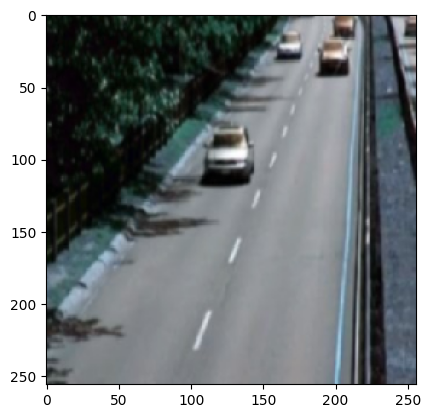

In [120]:
plt.imshow(sample_frame)

In [128]:
frames= generate_masked_frames(frames, masks)
sample_frame= frames[400]

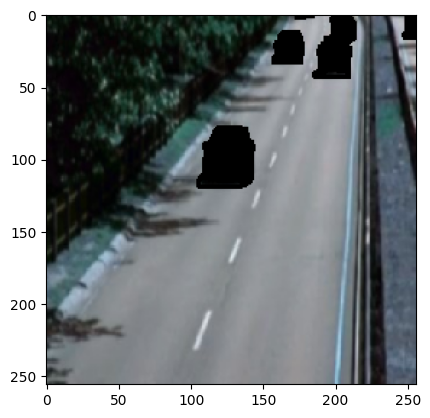

In [129]:
plt.imshow(sample_frame)

In [17]:
X_train, X_val, y_train, y_val= train_test_split(frames, outputs,  test_size=0.2, random_state=42)

In [21]:

X_train= np.array(X_train, dtype='float')
X_train/=255.0

X_val= np.array(X_val, dtype='float')
X_val/=255.0

y_train= np.array(y_train, dtype='float')
y_train/=255.0

y_val= np.array(y_val, dtype='float')
y_val/=255.0


In [22]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [27]:
class inpaintingModel:

    def prepare_model(self, input_size=(256,256,3)):
        inputs = keras.layers.Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
        conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 

        conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
        pool = keras.layers.MaxPooling2D(pool_size)(conv)
        return conv, pool
    else:
        return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = keras.layers.concatenate([up, shared_layer], axis=3)

        return conv, up

In [28]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

In [30]:
# with tf.device('/CPU:0'):
h= model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data= (X_val, y_val))

Epoch 1/20
110/110 [==============================] - 458s 4s/step - loss: 0.1182 - dice_coef: 0.6738 - val_loss: 0.0736 - val_dice_coef: 0.7007
Epoch 2/20
110/110 [==============================] - 461s 4s/step - loss: 0.0651 - dice_coef: 0.7005 - val_loss: 0.0583 - val_dice_coef: 0.7045
Epoch 3/20
110/110 [==============================] - 435s 4s/step - loss: 0.0511 - dice_coef: 0.7048 - val_loss: 0.0539 - val_dice_coef: 0.7089
Epoch 4/20
110/110 [==============================] - 413s 4s/step - loss: 0.0480 - dice_coef: 0.7056 - val_loss: 0.0451 - val_dice_coef: 0.6950
Epoch 5/20
110/110 [==============================] - 492s 4s/step - loss: 0.0450 - dice_coef: 0.7065 - val_loss: 0.0479 - val_dice_coef: 0.7095
Epoch 6/20
110/110 [==============================] - 491s 4s/step - loss: 0.0457 - dice_coef: 0.7078 - val_loss: 0.0459 - val_dice_coef: 0.7075
Epoch 7/20
110/110 [==============================] - 488s 4s/step - loss: 0.0443 - dice_coef: 0.7076 - val_loss: 0.0425 - val_dic

In [72]:
model.save('last_model.h5')

In [130]:
sample_frame= np.array(sample_frame, dtype= 'float')
sample_frame /= 255.0


In [131]:
sample_frame= [sample_frame]
sample_frame= np.array(sample_frame, dtype= 'float')


In [132]:
pred= model.predict(sample_frame)

1/1 [==============================] - 0s 106ms/step


In [133]:
pred.shape

(1, 256, 256, 3)

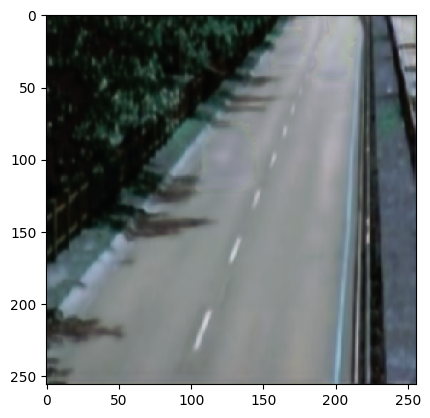

In [134]:
plt.imshow(pred[0])